## Importations

In [3]:
import pandas as pd
import numpy as np
import sqlalchemy as sql
import configparser
import datetime
import seaborn as sns
import matplotlib.pyplot as plt 
import io
import boto3
import json

## Configuration

In [4]:
config = configparser.ConfigParser()
config.read('../config/default.ini')

['../config/default.ini']

In [5]:
engine = sql.create_engine('postgresql://{}:{}@{}:{}/{}'.format(config['DATABASE']['username'], config['DATABASE']['password'].replace('_percentage_', '%'), config['DATABASE']['host'], config['DATABASE']['port'], config['DATABASE']['database']))

## Utilitaires

In [6]:
def export_df(df, name, date=True):
    df.to_csv('output/{}{}.csv'.format('{}_'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d')) if date else '', name), index=False, encoding='utf-8-sig')

In [7]:
def export_fig(plot, name, date=True):
    plot.savefig('images/{}{}.png'.format('{}_'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d')) if date else '', name))

In [8]:
def create_hierarchy(node, tree, hierarchy):
    hierarchy['name'] = node
    hierarchy['children'] = []
    keys = tree.keys()
    for child in [child for child in keys if child != 'leafs']:
        hierarchy['children'].append(create_hierarchy(child, tree[child], {}))   
    return hierarchy

## Données

### Read CSV

In [18]:
with open("input/cptall-fr.json") as file_newscodes:
    nc = json.loads(file_newscodes.read())
nc['conceptSet']

[{'uri': 'http://cv.iptc.org/newscodes/mediatopic/01000000',
  'qcode': 'medtop:01000000',
  'type': ['http://www.w3.org/2004/02/skos/core#Concept'],
  'inScheme': ['http://cv.iptc.org/newscodes/mediatopic/'],
  'modified': '2010-12-14T21:53:19+00:00',
  'prefLabel': {'fr': 'Arts, culture, divertissement et médias'},
  'definition': {'fr': "Toutes les formes d'arts, de divertissement, de culture et de médias"},
  'narrower': ['medtop:20000002', 'medtop:20000038', 'medtop:20000045'],
  'exactMatch': ['http://cv.iptc.org/newscodes/subjectcode/01000000'],
  'created': '2009-10-22T02:00:00+00:00'},
 {'uri': 'http://cv.iptc.org/newscodes/mediatopic/02000000',
  'qcode': 'medtop:02000000',
  'type': ['http://www.w3.org/2004/02/skos/core#Concept'],
  'inScheme': ['http://cv.iptc.org/newscodes/mediatopic/'],
  'modified': '2010-12-14T21:53:19+00:00',
  'prefLabel': {'fr': 'Criminalité, droit et justice'},
  'definition': {},
  'narrower': ['medtop:20000082',
   'medtop:20000106',
   'medtop:20

In [19]:
newscodes_dict = {line['uri']:line for line in nc['conceptSet']}
newscodes_dict

{'http://cv.iptc.org/newscodes/mediatopic/01000000': {'uri': 'http://cv.iptc.org/newscodes/mediatopic/01000000',
  'qcode': 'medtop:01000000',
  'type': ['http://www.w3.org/2004/02/skos/core#Concept'],
  'inScheme': ['http://cv.iptc.org/newscodes/mediatopic/'],
  'modified': '2010-12-14T21:53:19+00:00',
  'prefLabel': {'fr': 'Arts, culture, divertissement et médias'},
  'definition': {'fr': "Toutes les formes d'arts, de divertissement, de culture et de médias"},
  'narrower': ['medtop:20000002', 'medtop:20000038', 'medtop:20000045'],
  'exactMatch': ['http://cv.iptc.org/newscodes/subjectcode/01000000'],
  'created': '2009-10-22T02:00:00+00:00'},
 'http://cv.iptc.org/newscodes/mediatopic/02000000': {'uri': 'http://cv.iptc.org/newscodes/mediatopic/02000000',
  'qcode': 'medtop:02000000',
  'type': ['http://www.w3.org/2004/02/skos/core#Concept'],
  'inScheme': ['http://cv.iptc.org/newscodes/mediatopic/'],
  'modified': '2010-12-14T21:53:19+00:00',
  'prefLabel': {'fr': 'Criminalité, droit

In [20]:
def get_node(obj, branch):
    branch =  obj['uri']
    if 'broader' in obj:
        branch = '{}>{}'.format(get_node(newscodes_dict[obj['broader'][0]], branch), branch)
    return branch

In [21]:
newscodes = {}
for value in nc['conceptSet']:
    branch = get_node(value, value['uri'])  
    node = newscodes
    values = branch.split('>')
    for n in values:
        label = newscodes_dict[n]['prefLabel']['fr'] if 'fr' in newscodes_dict[n]['prefLabel'] else '' 
        if not label in node:
            node[label] = {}
        node = node[label]
    #newscodes[values[0]] = node
newscodes

{'Arts, culture, divertissement et médias': {'Arts et divertissement': {'Dessin animé': {},
   'Bande dessinée': {},
   'Cinéma': {},
   'Festival': {'Festival de cinéma': {}},
   'Danse': {'Danse classique': {},
    'Danse moderne': {},
    'Danse folklorique': {}},
   'Mode': {'Bijoux': {}, '': {}},
   'Littérature': {'Œuvre théâtrale': {},
    'Fiction': {},
    'Récit': {},
    'Poésie': {}},
   'Musique': {'Instrument de musique': {},
    'Concert': {},
    'Genre musical': {'Classique': {},
     'Country': {},
     'Folk': {},
     'Jazz': {},
     'Pop': {},
     'Rock': {},
     '': {}}},
   'Théâtre': {'Théâtre musical': {'Opéra': {},
     'Comédie musicale': {},
     'Opérette': {},
     '': {}},
    'Pièce de théâtre': {},
    '': {}},
   'Arts visuels': {'Architecture': {},
    'Design': {},
    'Dessin': {},
    'Peinture': {},
    'Photographie': {},
    'Sculpture': {},
    '': {}},
   'Exposition artistique': {},
   'Série': {}},
  'Culture': {"Histoire de l'art": {},
 

In [22]:
newscodes_hierarchy = create_hierarchy('', newscodes, {})
newscodes_hierarchy

{'name': '',
 'children': [{'name': 'Arts, culture, divertissement et médias',
   'children': [{'name': 'Arts et divertissement',
     'children': [{'name': 'Dessin animé', 'children': []},
      {'name': 'Bande dessinée', 'children': []},
      {'name': 'Cinéma', 'children': []},
      {'name': 'Festival',
       'children': [{'name': 'Festival de cinéma', 'children': []}]},
      {'name': 'Danse',
       'children': [{'name': 'Danse classique', 'children': []},
        {'name': 'Danse moderne', 'children': []},
        {'name': 'Danse folklorique', 'children': []}]},
      {'name': 'Mode',
       'children': [{'name': 'Bijoux', 'children': []},
        {'name': '', 'children': []}]},
      {'name': 'Littérature',
       'children': [{'name': 'Œuvre théâtrale', 'children': []},
        {'name': 'Fiction', 'children': []},
        {'name': 'Récit', 'children': []},
        {'name': 'Poésie', 'children': []}]},
      {'name': 'Musique',
       'children': [{'name': 'Instrument de musiqu

In [23]:
with open('output/{}_newscodes_taxonomy.json'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d')), 'w+') as jsonfile:
    jsonfile.write(json.dumps(newscodes_hierarchy))

In [9]:
with open("input/210203_mp_taxonomy_oaos.json") as file_oaos:
    oaos = json.loads(file_oaos.read())
oaos

{'name': '',
 'children': [{'name': 'info',
   'children': [{'name': 'Science, technologie et découvertes',
     'children': []},
    {'name': 'belgique',
     'children': [{'name': 'politique', 'children': []},
      {'name': 'justice', 'children': []},
      {'name': 'défense', 'children': []},
      {'name': 'élections', 'children': []}]},
    {'name': 'justice et police',
     'children': [{'name': 'enseignement', 'children': []},
      {'name': 'jeunesse', 'children': []},
      {'name': 'éducation aux médias', 'children': []}]},
    {'name': 'éducation', 'children': []},
    {'name': 'Europe', 'children': []},
    {'name': 'monde',
     'children': [{'name': 'Moyen orient', 'children': []},
      {'name': 'amérique du nord', 'children': []},
      {'name': 'amérique centrale', 'children': []},
      {'name': 'amérique du sud', 'children': []},
      {'name': 'asie', 'children': []},
      {'name': 'océanie', 'children': []}]},
    {'name': 'économie', 'children': []},
    {'name'

### Read from S3

In [4]:
s3 = boto3.client('s3')
bucket = 'big-data-media'
data = s3.get_object(Bucket=bucket, Key='playground/actito/output/attribution_firstname.csv')
df = pd.read_csv(io.BytesIO(data['Body'].read()), encoding='utf-8-sig')

In [12]:
df.count()

actitoid                            3538392
firstname                           3538392
lastname                            3538392
email                               3538392
birthdate                           3538392
language                            3538392
gender                              3538392
gsmnumber                           3538392
telnumber                           3538392
educationlevel                      3538392
profession                          3538392
is_gigya                             977631
marketingconsent                          2
addr_street                         3538392
addr_num                            3538392
addr_box                            3538392
city                                3538392
zip                                 3538392
country                             3538392
is_active                           3538392
blacklistrm                         3538392
source                              3538392
sourceoptin                     

In [ ]:
df.shape

In [ ]:
df.isnull().any()

## Graphs

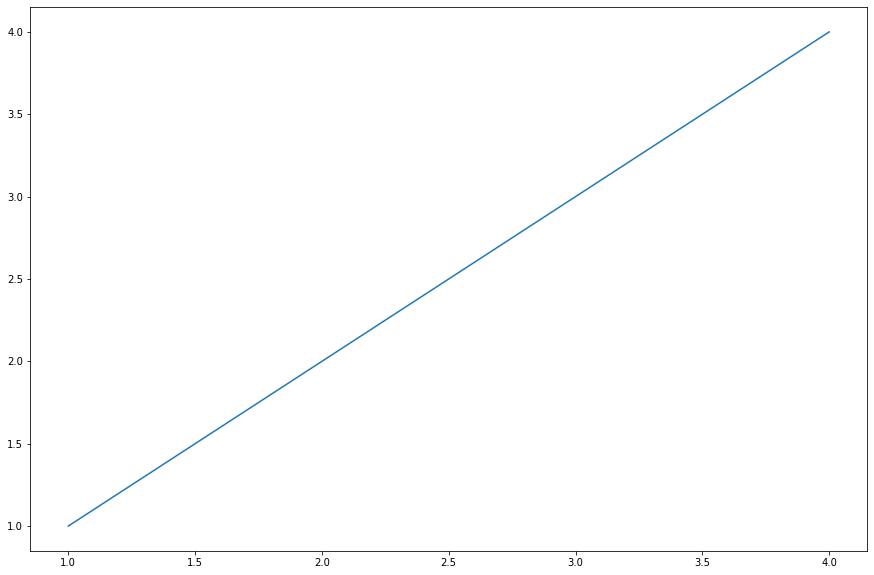

In [2]:
plt.figure(figsize = (15,10))
sns.lineplot(x=[1,2,3,4], y=[1,2,3,4])
plt.show()